<a href="https://colab.research.google.com/github/A-Istrate/80629_Project/blob/main/ML_TPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import math
import copy
from random import seed
from random import random
import matplotlib.pyplot as plt  # import matplotlib for plotting and visualization
import matplotlib
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import os
import re
import sklearn
from tensorflow.keras import layers
from sklearn.utils import class_weight

Checking our images

In [2]:
## images path
path_s = r"C:\Users\istra\Google Drive\Cours HEC\Maitrise\Semestre 2\Machine_Learning\TP GROUPE\book_covers2"
path = pathlib.Path(path_s)
image_count=len(list(path.glob('*/*.jpg')))
print(image_count)

43390


Checking a childrens book

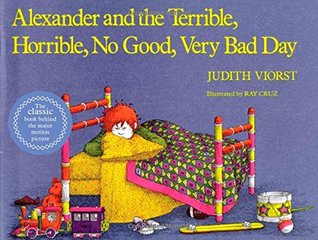

In [3]:
children = list(path.glob('Childrens/*'))
PIL.Image.open(str(children[12]))

Creating a dataset

In [5]:
batch_size =32
img_height = 150
img_width =100
list_ds = tf.data.Dataset.list_files(str(path_s+"\*/*.jp*"),shuffle=False)
list_ds = list_ds.shuffle(image_count,reshuffle_each_iteration=False)

In [6]:
for f in list_ds.take(5):
  print(f.numpy())

b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers2\\Sequential Art\\47700.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers2\\Fantasy\\41891.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers2\\Mystery & Crime\\52181.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers2\\Fantasy\\16384.jpg'
b'C:\\Users\\istra\\Google Drive\\Cours HEC\\Maitrise\\Semestre 2\\Machine_Learning\\TP GROUPE\\book_covers2\\Religion & Philosophy\\30867.jpg'


In [7]:
class_names = np.array(sorted([item.name for item in path.glob('*') if os.path.isdir(item)]))
print(class_names)

['Biography' 'Childrens' 'Fantasy' 'Historical' 'Horror' 'Mystery & Crime'
 'Poetry' 'Politics & History' 'Religion & Philosophy' 'Romance'
 'Science Fiction' 'Sequential Art' 'Young Adult']


In [36]:
val_size = int(image_count*0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [9]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

34712
8678


In [10]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  
  return tf.argmax(one_hot)

In [11]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [12]:
def process_path(file_path):
    label = get_label(file_path)
  # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
         
    return img,label


In [37]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)


Image shape:  (150, 100, 3)
Label:  6


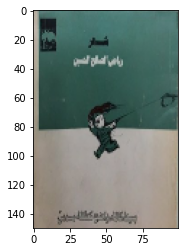

In [14]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
  plt.imshow(image.numpy().astype("uint8"))

In [38]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000, reshuffle_each_iteration=False)
  #print(ds)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

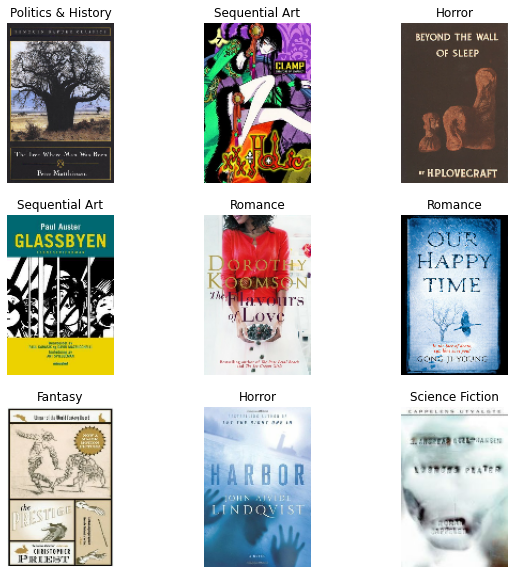

In [16]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

Classes

In [17]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
num_classes=14

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3,strides=1, activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(32, 3,strides=1,  activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(64, 3,strides=1,  activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])
model.compile(
   # optimizer=tf.keras.optimizers.RMSprop(
   # learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=0.001, 
  #  name='RMSprop'
#),
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        epsilon=0.1
    ),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [19]:
tclasses = [[c.numpy() for c in object[1]]for object in train_ds]
train_classes = np.concatenate(tclasses).ravel()
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_classes),
                                                 train_classes)

C:\Users\istra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12], y=[12  3 12 ...  0  8  3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [22]:
class_weights_dict =dict(enumerate(class_weights))
class_weights_dict

{0: 1.7083517889659925,
 1: 1.989682448698842,
 2: 0.38574889427244236,
 3: 0.7532168818487577,
 4: 2.56007080168154,
 5: 0.8433840322659021,
 6: 3.0904558404558404,
 7: 1.4992441584243943,
 8: 1.1107129143734802,
 9: 0.5151753513706051,
 10: 1.3101834377594928,
 11: 2.1091262607850285,
 12: 0.7427409864127528}

In [23]:
history=model.fit(
  train_ds,
  validation_data=val_ds,
  class_weight=class_weights_dict,
  epochs=50
)

Epoch 1/50
1085/1085 [==============================] - 206s 189ms/step - loss: 2.6096 - accuracy: 0.0767 - val_loss: 2.5934 - val_accuracy: 0.0637
Epoch 2/50
1085/1085 [==============================] - 238s 219ms/step - loss: 2.5505 - accuracy: 0.0632 - val_loss: 2.5869 - val_accuracy: 0.0389
Epoch 3/50
1085/1085 [==============================] - 228s 211ms/step - loss: 2.5319 - accuracy: 0.0747 - val_loss: 2.5553 - val_accuracy: 0.0701
Epoch 4/50
1085/1085 [==============================] - 240s 221ms/step - loss: 2.5004 - accuracy: 0.0862 - val_loss: 2.5289 - val_accuracy: 0.0880
Epoch 5/50
1085/1085 [==============================] - 241s 222ms/step - loss: 2.4890 - accuracy: 0.0941 - val_loss: 2.5285 - val_accuracy: 0.0888
Epoch 6/50
1085/1085 [==============================] - 220s 202ms/step - loss: 2.4702 - accuracy: 0.1011 - val_loss: 2.5113 - val_accuracy: 0.0966
Epoch 7/50
1085/1085 [==============================] - 220s 203ms/step - loss: 2.4600 - accuracy: 0.1098 - val_

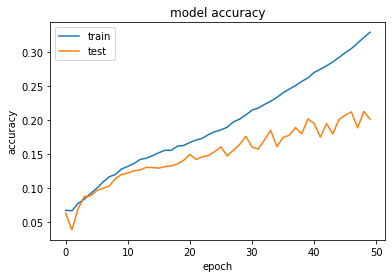

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
predictions = model.predict(val_ds)
predicted_classes = np.argmax(predictions, axis=1)

In [40]:
vclasses = list()
vclasses = [[c.numpy() for c in object[1]]for object in val_ds]

In [41]:
validation_classes = np.concatenate(vclasses).ravel()

In [42]:
np.mean(validation_classes==predicted_classes)

0.20131366674348927

In [43]:
from sklearn.metrics import classification_report
print(classification_report(validation_classes, predicted_classes, target_names=class_names))

                       precision    recall  f1-score   support

            Biography       0.13      0.13      0.13       407
            Childrens       0.16      0.42      0.23       294
              Fantasy       0.42      0.21      0.28      1731
           Historical       0.19      0.07      0.11       906
               Horror       0.13      0.24      0.17       259
      Mystery & Crime       0.27      0.25      0.26       781
               Poetry       0.07      0.16      0.10       228
   Politics & History       0.14      0.18      0.15       424
Religion & Philosophy       0.15      0.29      0.20       618
              Romance       0.34      0.21      0.26      1278
      Science Fiction       0.11      0.24      0.15       525
       Sequential Art       0.21      0.40      0.28       323
          Young Adult       0.23      0.08      0.12       904

             accuracy                           0.20      8678
            macro avg       0.20      0.22      0.19 

In [29]:
def prediction_score(valid,predictions,cnames=class_names):
    pred = np.argmax(predictions, axis=1)
    pred2 = np.argsort(predictions,axis=1)[:,-2]
    pred3 = np.argsort(predictions,axis=1)[:,-3]
    dict_c = dict(enumerate(cnames))
    scores=[]
    for v,p1,p2,p3 in zip(valid,pred,pred2,pred3):
        score=0
        if v == p1: score=1
        elif v == p2: score =0.75
        elif v == p3: score =0.5
        scores.append([dict_c.get(v),score])
    scores_df = pd.DataFrame(scores,columns=["genre","score"])
    meanscore =np.round(scores_df["score"].mean(),3)
    print("The average score is %s" %meanscore)
    return scores_df.groupby("genre").mean("score")

In [45]:
prediction_score(validation_classes,predictions)

The average score is 0.369


,score
genre,
Biography,0.236486
Childrens,0.552721
Fantasy,0.420277
Historical,0.216060
Horror,0.332046
Mystery & Crime,0.416453
Poetry,0.321272
Politics & History,0.326061
Religion & Philosophy,0.504450


In [47]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
num_classes=13

model2 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3,strides=1, activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(32, 3,strides=1,  activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(64, 3,strides=1,  activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])
model2.compile(
 
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001,
        epsilon=0.1
    ),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [48]:
history2=model2.fit(
  train_ds,
  validation_data=val_ds,
  class_weight=class_weights_dict,
  epochs=50
)

Epoch 1/50
1085/1085 [==============================] - 175s 159ms/step - loss: 2.5678 - accuracy: 0.0673 - val_loss: 2.5589 - val_accuracy: 0.0926
Epoch 2/50
1085/1085 [==============================] - 156s 144ms/step - loss: 2.5492 - accuracy: 0.0796 - val_loss: 2.5293 - val_accuracy: 0.0882
Epoch 3/50
1085/1085 [==============================] - 155s 143ms/step - loss: 2.5247 - accuracy: 0.0913 - val_loss: 2.5168 - val_accuracy: 0.0884
Epoch 4/50
1085/1085 [==============================] - 159s 146ms/step - loss: 2.4921 - accuracy: 0.1091 - val_loss: 2.4896 - val_accuracy: 0.1075
Epoch 5/50
1085/1085 [==============================] - 159s 146ms/step - loss: 2.4762 - accuracy: 0.1158 - val_loss: 2.4695 - val_accuracy: 0.1097
Epoch 6/50
1085/1085 [==============================] - 156s 144ms/step - loss: 2.4555 - accuracy: 0.1244 - val_loss: 2.4450 - val_accuracy: 0.1348
Epoch 7/50
1085/1085 [==============================] - 156s 144ms/step - loss: 2.4369 - accuracy: 0.1260 - val_

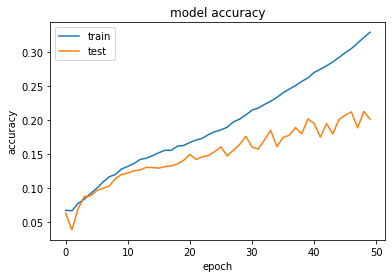

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [50]:
model2.save("wheighted_classes_27.h5")

In [62]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
num_classes=13

model3 = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3,strides=1, activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(32, 3,strides=1,  activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(64, 3,strides=1,  activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Conv2D(128, 3,strides=1,  activation='relu'),
  layers.Dropout(0.5),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])
model3.compile(
 
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.01,
        epsilon=0.1
    ),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [64]:
history3=model3.fit(
  train_ds,
  validation_data=val_ds,
  class_weight=class_weights_dict,
  epochs=50
)

1085/1085 [==============================] - 240s 222ms/step - loss: 2.1692 - accuracy: 0.1874 - val_loss: 2.3649 - val_accuracy: 0.1501
Epoch 34/50
 482/1085 [============>.................] - ETA: 2:06 - loss: 2.1839 - accuracy: 0.1846

KeyboardInterrupt: 

Epoch 1/50
 151/1085 [===>..........................] - ETA: 3:35 - loss: 2.1518 - accuracy: 0.1871

KeyboardInterrupt: 